Code additions and changes by Konstantinos Prokopidis and Iordanis Tassopoulos


# Introduction
This kernel has been created by the [Information Systems Lab](http://islab.uom.gr) to introduce students of the [University of Macedonia](http://www.uom.gr/index.php?tmima=2&categorymenu=2), Greece to Machine Learning & Data Science.

## The Instacart competition
Instacart is an American company that operates as a same-day grocery delivery service. Customers select groceries through a web application from various retailers and delivered by a personal shopper. Instacart's service is mainly provided through a smartphone app, available on iOS and Android platforms, apart from its website.

In 2017 Instacart organised a Kaggle competition and provided to the community a sample dataset of over 3 million grocery orders from more than 200,000 Instacart users. The orders include 32 million basket items and 50,000 unique products. The objective of the competition was participants to **predict which previously purchased products will be in a user’s next order**.

## Objective
The objective of this Kernel is to introduce students to predictive business analytics with Python through the Instacart case. 

By the time you finish this example, you will be able to:
* Describe the steps of creating a predictive analytics model
* Use Python and Pandas package to manipulate data
* Use Python and Pandas package to create, combine, and delete DataFrames
* Use Random Forests to create a predictive model
* Apply the predictive model in order to make a prediction
* Create a submission file for the competition of Instacart

## Problem definition
The data that Instacart opened up include orders of 200,000 Instacart users with each user having between 4 and 100 orders. Instacart indicates each order in the data as prior, train or test. Prior orders describe the **past behaviour** of a user while train and test orders regard the **future behaviour that we need to predict**. 

As a result, we want to predict which previously purchased products (prior orders) will be in a user’s next order (train and test orders). 

For the train orders Instacart reveals the results (i.e., the ordered products) while for the test orders we do not have this piece of information. Moreover, the future order of each user can be either train or test meaning that each user will be either a train or a test user. 

The setting of the Instacart problem is described in the figure below (orders with yellow color denotes future orders of a user). 

<img src="https://i.imgur.com/S0Miw3m.png" width="350">

Each user has purchased various products during their prior orders. Moreover, for each user we know the order_id of their future order. The goal is to predict which of these products will be in a user's future order. 

This is a **classification problem** because we need to predict whether each pair of user and product is a reorder or not. This is indicated by the value of the reordered variable, i.e. reordered=1 or reordered=0 (see figure below). 

<img src="https://i.imgur.com/SxK2gsR.png" width="350">

As a result we need to come up and calculate various **predictor variables (X)** that will describe the characteristics of a product and the behaviour of a user regarding one or multiple products. We will do so by analysing the prior orders of the dataset. We will then use the train users to create a predictive model and the test users to make our actual prediction. As a result we create a table as the following one and we train an algorithm based on predictor variables (X) and response variable (Y).

<img src="https://i.imgur.com/Yb1CKAF.png" width="600">

## Method
Our method includes the following steps:
1. <b>Import and reshape data</b>: This step includes loading CSV files into pandas DataFrames, tranform character variables to categorical variables, and create a supportive table.
2. <b>Create predictor variables</b>: This step includes identifying and calculating predictor variables (aka features) from the initial datasets provided by Instacart. 
3. <b>Create train and test DataFrames</b>: In this step we create two distinct pandas DataFrames that will be used in the creation and the use of the predictive model.
4. <b>Create predictive model (fit)</b>: In this step we train a predictive model through the train dataset.
5. <b>Apply predictive model (predict)</b>: This step includes applying the model to predict the 'reordered' variable for the test dataset.
6. <b>Create submission file</b>: In this final step we create the submission file with our predictions for Instacart's competition.
7. <b>Get F1 score</b>: In this step we submit the produced and file and get the F1 score describing the accuracy of our prediction model.

# 1. Import and Reshape Data 
First we load the necessary Python packages and then we import the CSV files that were provided by Instacart.

## 1.1 Import the required packages
The garbage collector (package gc), attempts to reclaim garbage, or memory occupied by objects (e.g., DataFrames) that are no longer in use by Python ([ref1](https://www.techopedia.com/definition/1083/garbage-collection-gc-general-programming), [ref2](https://en.wikipedia.org/wiki/Garbage_collection_(computer_science)). This package will eliminate our risk to exceed the 16GB threshold of available RAM that Kaggle offers.

The **"as"** reserved word is to define an alias to the package. The alias help us to call easier a package in our code.

In [1]:
# For data manipulation
import pandas as pd         

# Garbage Collector to free up memory
import gc                         
gc.enable()                       # Activate 

## 1.2 Load data from the CSV files
Instacart provides 6 CSV files, which we have to load into Python. Towards this end, we use the .read_csv() function, which is included in the Pandas package. Reading in data with the .read_csv( ) function returns a DataFrame.

### 1.2.1 Colab environment

First we connect to the Kaggle API in order to download the zip file with the 6 CSVs. Then we unzip it in a new folder named input, and we unzip all the zip files.

In [ ]:
#This is for Google Colab
from google.colab import files
files.upload() #upload kaggle.json

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# connect to kaggle api and download files (zip)
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi({"username":"kprokopi","key":"9a28305a56476ed46a0ac149764d9610"})
api.authenticate()
files = api.competition_download_files("Instacart-Market-Basket-Analysis")

In [ ]:
import zipfile
with zipfile.ZipFile('Instacart-Market-Basket-Analysis.zip', 'r') as zip_ref:
    zip_ref.extractall('./input')

In [ ]:
import os
working_directory = os.getcwd()+'/input'
os.chdir(working_directory)
for file in os.listdir(working_directory):   # get the list of files
    if zipfile.is_zipfile(file): # if it is a zipfile, extract it
        with zipfile.ZipFile(file) as item: # treat the file as a zip
           item.extractall()  # extract it in the working directory

In [ ]:
orders = pd.read_csv('../input/orders.csv')
order_products_train = pd.read_csv('../input/order_products__train.csv')
order_products_prior = pd.read_csv('../input/order_products__prior.csv')
products = pd.read_csv('../input/products.csv')
aisles = pd.read_csv('../input/aisles.csv')
departments = pd.read_csv('../input/departments.csv')

### 1.2.2 Kaggle environment
When we run the code in kaggle, we use the following code to load data:

In [ ]:
'''
orders = pd.read_csv('../input/instacart-market-basket-analysis/orders.csv')
order_products_train = pd.read_csv('../input/instacart-market-basket-analysis/order_products__train.csv')
order_products_prior = pd.read_csv('../input/instacart-market-basket-analysis/order_products__prior.csv')
products = pd.read_csv('../input/instacart-market-basket-analysis/products.csv')
aisles = pd.read_csv('../input/instacart-market-basket-analysis/aisles.csv')
departments = pd.read_csv('../input/instacart-market-basket-analysis/departments.csv')
'''

### 1.2.3 Local machine
In case we load the csv files from the local disk we run the following code:

In [2]:
import os #package to get the working directory

#cwd is the current directory of the data folder
cwd = os.getcwd()
print('The working directory is : '+cwd)
#csv files are in the input directory
path_orders=cwd+'\\input\\orders.csv'
path_order_products_train =cwd+'\\input\\order_products__train.csv'
path_order_products_prior=cwd+'\\input\\order_products__prior.csv'
path_products=cwd+'\\input\\products.csv'
path_aisles=cwd+'\\input\\aisles.csv'
path_departments=cwd+'\\input\\departments.csv'

orders = pd.read_csv(path_orders) #read orders.csv
order_products_train = pd.read_csv(path_order_products_train)
order_products_prior = pd.read_csv(path_order_products_prior)
products = pd.read_csv(path_products)
aisles = pd.read_csv(path_aisles)
departments = pd.read_csv(path_departments)


The working directory is : C:\Users\kprokopi\Desktop\instacart


This step results in the following DataFrames:
* <b>orders</b>: This table includes all orders, namely prior, train, and test. It has single primary key (<b>order_id</b>).
* <b>order_products_train</b>: This table includes training orders. It has a composite primary key (<b>order_id and product_id</b>) and indicates whether a product in an order is a reorder or not (through the reordered variable).
* <b>order_products_prior </b>: This table includes prior orders. It has a composite primary key (<b>order_id and product_id</b>) and indicates whether a product in an order is a reorder or not (through the reordered variable).
* <b>products</b>: This table includes all products. It has a single primary key (<b>product_id</b>)
* <b>aisles</b>: This table includes all aisles. It has a single primary key (<b>aisle_id</b>)
* <b>departments</b>: This table includes all departments. It has a single primary key (<b>department_id</b>)

If you want to reduce the execution time of this Kernel you can use the following piece of code by uncomment it. This will trim the orders DataFrame and will keep a 10% random sample of the users. You can use this for experimentation.

In [3]:

#### Remove triple quotes to trim your dataset and experiment with your data
### COMMANDS FOR CODING TESTING - Get 1% of users 
orders = orders.loc[orders.user_id.isin(orders.user_id.drop_duplicates().sample(frac=0.01, random_state=25))] 


We now use the .head( ) method in order to visualise the first 10 rows of these tables. Click the Output button below to see the tables.

In [4]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
421,2064090,29,prior,1,5,11,NaN
422,875452,29,prior,2,2,8,11.0
423,2657652,29,prior,3,2,10,14.0
424,2999889,29,prior,4,6,8,11.0
425,1207762,29,prior,5,1,11,9.0


We add a new column to orders dataframe named 'days_since_first_order' which accumulates the days since the first order of the user

In [5]:
#Add a new column the 'days_since_first_order'

#The Nan values of the column days_since_prior_order are changed to zero
orders['days_since_prior_order']=orders['days_since_prior_order'].fillna(0)

#The column days_since_first_order is calculated by adding of the value of days_since_prior_oder to the value
#of the previous order for each user using function cumsum()
orders['days_since_first_order']=orders.groupby('user_id')['days_since_prior_order'].apply(lambda x: x.cumsum())


In [ ]:
order_products_train.head()

In [ ]:
order_products_prior.head()

In [ ]:
products.head()

In [ ]:
aisles.head()

In [ ]:
departments.head()

## 1.3a Reshape data
We transform the data in order to facilitate their further analysis. First, we convert character variables into categories so we can use them in the creation of the model. In Python, a categorical variable is called category and has a fixed number of different values.

In [6]:
# We convert character variables into category. 
# In Python, a categorical variable is called category and has a fixed number of different values
aisles['aisle'] = aisles['aisle'].astype('category')
departments['department'] = departments['department'].astype('category')
orders['eval_set'] = orders['eval_set'].astype('category')
products['product_name'] = products['product_name'].astype('category')

## 1.3b Addition of three categories for some products
We add three categories for some products (organic, gluten free and asian). We will use the three categories in the future to create features. If a product belongs to the category we put 1 in the relevant column otherwise 0. We use the function map()

In [7]:
products['product_is_organic']=products.product_name.map(lambda x:'organic' in x.lower())*1
products['product_is_gluten_free']=products.product_name.map(lambda x: 'gluten' in x.lower() and 'free' in x.lower())*1
products['product_is_asian']=products.product_name.map(lambda x: 'asian' in x.lower())*1
products.head(30)

,product_id,product_name,aisle_id,department_id,product_is_organic,product_is_gluten_free,product_is_asian
0,1,Chocolate Sandwich Cookies,61,19,0,0,0
1,2,All-Seasons Salt,104,13,0,0,0
2,3,Robust Golden Unsweetened Oolong Tea,94,7,0,0,0
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,0,0,0
4,5,Green Chile Anytime Sauce,5,13,0,0,0
5,6,Dry Nose Oil,11,11,0,0,0
6,7,Pure Coconut Water With Orange,98,7,0,0,0
7,8,Cut Russet Potatoes Steam N' Mash,116,1,0,0,0
8,9,Light Strawberry Blueberry Yogurt,120,16,0,0,0
9,10,Sparkling Orange Juice & Prickly Pear Beverage,115,7,0,0,0


## 1.4 Create a DataFrame with the orders and the products that have been purchased on prior orders (op) 📚📝
We create a new DataFrame, named <b>op</b> which combines (merges) the DataFrames <b>orders</b> and <b>order_products_prior</b>. Bear in mind that <b>order_products_prior</b> DataFrame includes only prior orders, so the new DataFrame <b>op</b>  will contain only these observations as well. Towards this end, we use pandas' merge function with how='inner' argument, which returns records that have matching values in both DataFrames. 
<img src="https://i.imgur.com/zEK7FpY.jpg" width="400">

In [8]:
#Merge the orders DF with order_products_prior by their order_id, keep only these rows with order_id that they are appear on both DFs
op = orders.merge(order_products_prior, on='order_id', how='inner') ##
op.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,days_since_first_order,product_id,add_to_cart_order,reordered
0,2064090,29,prior,1,5,11,0.0,0.0,49615,1,0
1,2064090,29,prior,1,5,11,0.0,0.0,39170,2,0
2,2064090,29,prior,1,5,11,0.0,0.0,48800,3,0
3,2064090,29,prior,1,5,11,0.0,0.0,39185,4,0
4,2064090,29,prior,1,5,11,0.0,0.0,36543,5,0


The table contains for all the customers **(user_id)**: <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ➡︎ the orders **(order_id)** that they have placed accompanied with: <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ➡︎ the products **(product_id)** that have been bought in each order

In [9]:
op=op.merge(products,on='product_id',how='inner')
op=op.drop(['product_name','aisle_id','department_id'],axis=1)
op.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,days_since_first_order,product_id,add_to_cart_order,reordered,product_is_organic,product_is_gluten_free,product_is_asian
0,2064090,29,prior,1,5,11,0.0,0.0,49615,1,0,0,0,0
1,875452,29,prior,2,2,8,11.0,11.0,49615,3,1,0,0,0
2,2657652,29,prior,3,2,10,14.0,25.0,49615,3,1,0,0,0
3,2999889,29,prior,4,6,8,11.0,36.0,49615,3,1,0,0,0
4,1207762,29,prior,5,1,11,9.0,45.0,49615,5,1,0,0,0


# 2. Create Predictor Variables
We are now ready to identify and calculate predictor variables based on the provided data. We can create various types of predictors such as:
* <b>User predictors</b> describing the behavior of a user e.g. total number of orders of a user.
* <b>Product predictors</b> describing characteristics of a product e.g. total number of times a product has been purchased.
* <b>User & product predictors</b> describing the behavior of a user towards a specific product e.g. total times a user ordered a specific product.

## 2.1 Create user predictors
We create the following predictors:
- 2.1.1 Number of orders per customer (**u_total_orders**)
- 2.1.2 The mean time period in days between two consecutive orders of a customer (**u_mean_period**)
- 2.1.3 How frequently a customer has reordered products (**u_reordered_ratio**)
- 2.1.4 Number of products per customer (**u_total_products**) of all purchases
- 2.1.5 Number of unique products per customer (**u_total_unique_products**) of all purchases
- 2.1.6 The ratio of organic, gluten free and asian products of each customer in purchases (**organic_ratio**, **gluten_free_ratio**, **asian_ratio**)


### 2.1.1 Number of orders per customer
We calculate the total number of placed orders per customer. We create a **user** DataFrame to store the results.

In [10]:
## First approach in one step:
# Create distinct groups for each user, identify the highest order number in each group, save the new column to a DataFrame
user = op.groupby('user_id')['order_number'].max().to_frame('u_total_orders')
user.head()

## Second approach in two steps: 
#1. Save the result as DataFrame with Double brackets --> [[ ]] 
#user = op.groupby('user_id')[['order_number']].max()
#2. Rename the label of the column
#user.columns = ['u_total_orders']
#user.head()

,u_total_orders
user_id,
29,18
75,23
245,5
364,18
552,12


In [11]:
# Reset the index of the DF so to bring user_id from index to column (pre-requisite for step 2.4)
user = user.reset_index()
user.head()

,user_id,u_total_orders
0,29,18
1,75,23
2,245,5
3,364,18
4,552,12


### 2.1.2 The mean time period in days between two consecutive orders of a customer

In [12]:
#We groupby user_id and calculate the mean value
u_mean_period = orders.groupby('user_id')['days_since_prior_order'].mean().to_frame('u_mean_period')
u_mean_period = u_mean_period.reset_index()
u_mean_period.head()

,user_id,u_mean_period
0,29,11.000000
1,75,8.375000
2,245,23.333333
3,364,13.526316
4,552,12.000000


### 2.1.3 How frequently a customer has reordered products 📚📝
 
This feature is a ratio which shows for each user in what extent has products that have been reordered in the past: <br>
So we create the following ratio: <br>

<img src="https://latex.codecogs.com/gif.latex?\dpi{120}&space;\large&space;probability\&space;reordered\&space;(user\_id)=&space;\frac{total\&space;times\&space;of\&space;reorders}{total\&space;number\&space;of\&space;purchased\&space;products\&space;from\&space;all\&space;baskets}" title="probability\ reordered\ (user\_id)= \frac{total\ times\ of\ reorders}{total\ number\ of\ purchased\ products\ from\ all\ baskets}" />

The nominator is a counter for all the times a user has reordered products (value on reordered=1), the denominator is a counter of all the products that have been purchased on all user's orders (reordered=0 & reordered=1).

E.g., for a user that has ordered 6 products in total, where 3 times were reorders, the ratio will be:

![example ratio](https://latex.codecogs.com/gif.latex?\dpi{120}&space;\large&space;&space;mean=&space;\frac{0&plus;1&plus;0&plus;0&plus;1&plus;1}{6}&space;=&space;0,5) 

To create the above ratio we .groupby() order_products_prior by each user and then calculate the mean of reordered.


In [13]:
u_reorder = op.groupby('user_id')['reordered'].mean().to_frame('u_reordered_ratio') #
u_reorder = u_reorder.reset_index()
u_reorder.head()

,user_id,u_reordered_ratio
0,29,0.702222
1,75,0.681672
2,245,0.276596
3,364,0.677966
4,552,0.685714


### 2.1.4 Number of products per customer (**u_total_products**) of all purchases

We calculate the total number of products (not unique) the customer bought in all his/her orders 

In [14]:
# Create distinct groups for each user and order_id, identify the highest order number in each group, save the new column to a DataFrame
user_total_products = op.groupby(['user_id'])['product_id'].count().to_frame('u_total_products')
user_total_products = user_total_products.reset_index()
user_total_products.head()

,user_id,u_total_products
0,29,225
1,75,311
2,245,47
3,364,177
4,552,70


### 2.1.5 Number of unique products per customer (**u_total_unique_products**) of all purchases

In [15]:
user_total_unique_products = op.groupby(['user_id'])['product_id'].nunique().to_frame('u_total_unique_products')
user_total_unique_products = user_total_unique_products.reset_index()
user_total_unique_products.head()

,user_id,u_total_unique_products
0,29,67
1,75,99
2,245,34
3,364,57
4,552,22


### 2.1.6 The ratio of organic, gluten free and asian products of each customer in purchases (**organic_ratio**, **gluten_free_ratio**, **asian_ratio**)
We count for each customer the number of organic, gluten free and asian products and the we calculate the ratio

In [16]:
user_habit=op.groupby(['user_id'])['product_is_organic'].sum().to_frame('organic_count')
user_habit['gluten_free_count']=op.groupby(['user_id'])['product_is_gluten_free'].sum()
user_habit['asian_count']=op.groupby(['user_id'])['product_is_asian'].sum()
user_habit = user_habit.reset_index()
user_habit.head()


,user_id,organic_count,gluten_free_count,asian_count
0,29,0,2,0
1,75,91,46,0
2,245,21,0,0
3,364,59,0,0
4,552,23,0,0


We calculate the ratio 'organic_ratio' as $\frac{\textrm{number of products which bought the user and are organic}}{\textrm{total number of products which bought}}$. The features 'gluten_free_ratio' and 'asian_ratio' are estimated similarly.

The new feature will be merged with the user DataFrame (section 2.1.1) which keep all the features based on users. We perform a left join as we want to keep all the users that we have created on the user DataFrame

<img src="https://i.imgur.com/wMmC4hb.jpg" width="400">

Similarly we merge the dataframes of all other features

In [17]:
user = user.merge(u_reorder, on='user_id', how='left') 

user=user.merge(u_mean_period, on='user_id', how='left')

user=user.merge(user_total_products, on='user_id', how='left')

user=user.merge(user_total_unique_products, on='user_id', how='left')
                
user=user.merge(user_habit, on='user_id', how='left')  
                
user['organic_ratio']=user['organic_count']/user['u_total_products']
user['gluten_free_ratio']=user['gluten_free_count']/user['u_total_products']
user['asian_ratio']=user['asian_count']/user['u_total_products']

#we drop the columns we don't need any more
user=user.drop(['organic_count','gluten_free_count','asian_count'],axis=1)

del u_reorder, u_mean_period, user_total_products, user_total_unique_products, user_habit
gc.collect()

user.head()

,user_id,u_total_orders,u_reordered_ratio,u_mean_period,u_total_products,u_total_unique_products,organic_ratio,gluten_free_ratio,asian_ratio
0,29,18,0.702222,11.000000,225,67,0.000000,0.008889,0.0
1,75,23,0.681672,8.375000,311,99,0.292605,0.147910,0.0
2,245,5,0.276596,23.333333,47,34,0.446809,0.000000,0.0
3,364,18,0.677966,13.526316,177,57,0.333333,0.000000,0.0
4,552,12,0.685714,12.000000,70,22,0.328571,0.000000,0.0


## 2.2 Create product predictors
We create the following predictors:
- 2.2.1 Number of purchases for each product (**p_total_purchases**)
- 2.2.2 What is the probability for a product to be reordered (**p_reorder**)
- 2.2.3 Number of purchases for each department a product belongs to (**dept_t_purchases**)
- 2.2.4 One-shot ratio of a product (**one_shot_ratio**)

### 2.2.1 Number of purchases for each product
We calculate the total number of purchases for each product (from all customers). We create a **prd** DataFrame to store the results.

In [18]:
# Create distinct groups for each product, count the orders, save the result for each product to a new DataFrame  
prd = op.groupby('product_id')['order_id'].count().to_frame('p_total_purchases')
prd.head()

,p_total_purchases
product_id,
1,31
3,4
4,1
9,6
10,28


In [19]:
# Reset the index of the DF so to bring product_id rom index to column (pre-requisite for step 2.4)
prd = prd.reset_index()
prd.head()

,product_id,p_total_purchases
0,1,31
1,3,4
2,4,1
3,9,6
4,10,28


## 2.2.2 What is the probability for a product to be reordered
In this section we want to find the products which have the highest probability of being reordered. Towards this end it is necessary to define the probability as below:
<img src="https://latex.codecogs.com/gif.latex?\dpi{150}&space;\large&space;probability\&space;reordered\&space;(product\_id)=&space;\frac{number\&space;of\&space;reorders}{total\&space;number\&space;of\&space;orders\&space;}" title="probability\ reordered\ (product\_id)= \frac{number\ of\ reorders}{total\ number\ of\ orders\ }" />

Example: The product with product_id=2 is included in 90 purchases but only 12 are reorders. So we have:  

<img src="https://latex.codecogs.com/gif.latex?\dpi{150}&space;\large&space;p\_reorder\(product\_id\mathop{==}&space;2&space;)=&space;\frac{12}{90}=&space;0,133" title="\large p\_reorder\(product\_id\mathop{==} 2 )= \frac{12}{90}= 0,133" />

### 2.2.2.1 Remove products with less than 40 purchases - Filter with .shape[0]
Before we proceed to this estimation, we remove all these products that have less than 40 purchases in order the calculation of the aforementioned ratio to be meaningful.

Using .groupby() we create groups for each product and using .filter( ) we keep only groups with more than 40 rows. Towards this end, we indicate a lambda function.

In [20]:
# execution time: 25 sec
# the x on lambda function is a temporary variable which represents each group
# shape[0] on a DataFrame returns the number of rows
p_reorder = op.groupby('product_id').filter(lambda x: x.shape[0] >40)
p_reorder.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,days_since_first_order,product_id,add_to_cart_order,reordered,product_is_organic,product_is_gluten_free,product_is_asian
0,2064090,29,prior,1,5,11,0.0,0.0,49615,1,0,0,0,0
1,875452,29,prior,2,2,8,11.0,11.0,49615,3,1,0,0,0
2,2657652,29,prior,3,2,10,14.0,25.0,49615,3,1,0,0,0
3,2999889,29,prior,4,6,8,11.0,36.0,49615,3,1,0,0,0
4,1207762,29,prior,5,1,11,9.0,45.0,49615,5,1,0,0,0


### 2.2.2.2 Group products, calculate the mean of reorders

To calculate the reorder probability we will use the aggregation function mean() to the reordered column. In the reorder data frame, the reordered column indicates that a product has been reordered when the value is 1.

The .mean() calculates how many times a product has been reordered, divided by how many times has been ordered in total. 

E.g., for a product that has been ordered 9 times in total, where 4 times has been reordered, the ratio will be:

![example ratio](https://latex.codecogs.com/gif.latex?\dpi{120}&space;\large&space;&space;mean=&space;\frac{0&plus;1&plus;0&plus;0&plus;1&plus;1&plus;0&plus;0&plus;1}{9}&space;=&space;0,44) 

We calculate the ratio for each product. The aggregation function is limited to column 'reordered' and it calculates the mean value of each group.

In [21]:
p_reorder = p_reorder.groupby('product_id')['reordered'].mean().to_frame('p_reorder_ratio')
p_reorder = p_reorder.reset_index()
p_reorder.head()

,product_id,p_reorder_ratio
0,34,0.625000
1,45,0.535211
2,116,0.645833
3,117,0.854167
4,130,0.674419


### 2.2.2.3 Merge the new feature on prd DataFrame
The new feature will be merged with the prd DataFrame (section 2.2.1) which keep all the features based on products. We perform a left join as we want to keep all the products that we have created on the prd DataFrame
<img src="https://i.imgur.com/dOVWPKb.jpg" width="400">

In [22]:
#Merge the prd DataFrame with reorder
prd = prd.merge(p_reorder, on='product_id', how='left')

#delete the reorder DataFrame
del p_reorder
gc.collect()

prd.head()

,product_id,p_total_purchases,p_reorder_ratio
0,1,31,NaN
1,3,4,NaN
2,4,1,NaN
3,9,6,NaN
4,10,28,NaN


#### 2.2.2.4 Fill NaN values 📚📝
As you may notice, there are product with NaN values. This regards the products that have been purchased less than 40 times from all users and were not included in the p_reorder DataFrame. **As we performed a left join with prd DataFrame, all the rows with products that had less than 40 purchases from all users, will get a NaN value.**

For these products we their NaN value with zero (0):

In [23]:
prd['p_reorder_ratio'] = prd['p_reorder_ratio'].fillna(0) #
prd.head()

,product_id,p_total_purchases,p_reorder_ratio
0,1,31,0.0
1,3,4,0.0
2,4,1,0.0
3,9,6,0.0
4,10,28,0.0


> Our final DataFrame should not have any NaN values, otherwise the fitting process (chapter 4) will throw an error!


### 2.2.3 Number of purchases for each department a product belongs to

We estimate the number of purchases for each department and then we assign the number of total purchases of the department to each product


In [24]:
#We merge the prd (dataframe of the total purchases per product) with the products dataframe in order to insert 
#the department_id
dep=prd.merge(products, on='product_id', how='left')
dep.head()

,product_id,p_total_purchases,p_reorder_ratio,product_name,aisle_id,department_id,product_is_organic,product_is_gluten_free,product_is_asian
0,1,31,0.0,Chocolate Sandwich Cookies,61,19,0,0,0
1,3,4,0.0,Robust Golden Unsweetened Oolong Tea,94,7,0,0,0
2,4,1,0.0,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,0,0,0
3,9,6,0.0,Light Strawberry Blueberry Yogurt,120,16,0,0,0
4,10,28,0.0,Sparkling Orange Juice & Prickly Pear Beverage,115,7,0,0,0


In [25]:
#We count using groupby the total purchases for each department_id
prod_dep=dep.groupby('department_id')['p_total_purchases'].count()
prod_dep = prod_dep.reset_index()
prod_dep.head(30)

#We merge the products dataframe with the prod_dep
prod_department=products.merge(prod_dep,on='department_id',how='left')
#we keep only 2 columns
prod_department=prod_department[['product_id','p_total_purchases']]
#we rename the column
prod_department=prod_department.rename(columns={'p_total_purchases':'dept_t_purchases'})
prod_department.head(30)

,product_id,dept_t_purchases
0,1,2632
1,2,2308
2,3,1864
3,4,2058
4,5,2308
5,6,1616
6,7,1864
7,8,2058
8,9,1960
9,10,1864


### 2.2.4 One-shot ratio of a product
For each product (product_id) we calculate a ratio that consists of the total number of customers who bought a product only once divided by the total number of customers who bought this product.

A high one-shot ratio of a product means that customers tend not to reorder this product. To calculate this ratio we have to compute:

*     the number of users bought it only once (count)
*     the number of unique customers of a product (count)

In [26]:
# How many times each customer bought a product
item = op.groupby(['product_id', 'user_id'])[['order_id']].count() 
item.columns = ['total']
item.head()

# How many times each customer bought a product only 1
item_one = item[item.total==1]
item_one.head()

#How many customers bought each product only 1
item_one = item_one.groupby('product_id')[['total']].count()
item_one.columns = ['customers_one_shot']
item_one.head()

#Number of unique customers of a product
item=item.reset_index(1)
item_size = item.groupby('product_id')[['user_id']].count()
item_size.columns = ['unique_customers']
item_size.head()

# One Shot ratio
results = pd.merge(item_size, item_one, on='product_id', how='left')
results['one_shot_ratio'] =  results['customers_one_shot'] /results['unique_customers']
results.head()

# fill NaN Values There are cases where none customer bought a product only one time
results = results.fillna(0)
results = results.drop(['unique_customers', 'customers_one_shot'], axis=1)
results = results.reset_index()
results.head()

del item, item_one, item_size
gc.collect()



13

## 2.3 Create user-product predictors
We create the following predictors:
- 2.3.1 How many times a user bought a product (**uxp_total_bought**)
- 2.3.2 How frequently a customer bought a product after its first purchase ? (**uxp_reorder_ratio**) and the number of orders since user’s last order of a product (**uxp_orders_since_last_order**)
- 2.3.3 For each user and product which is the average number of days between orders (**uxp_average_days_between_orders**)
- 2.3.4 For a each user we find the average position of a product on its order (**mean_add_to_cart_order**)
- 2.3.5 How many times a customer bought a product on its last N orders (**times_lastN**) 

### 2.3.1 How many times a user bought a product
We create different groups that contain all the rows for each combination of user and product. With the aggregation function .count( ) we get how many times each user bought a product. We save the results on new **uxp** DataFrame.

In [27]:
# Create distinct groups for each combination of user and product, count orders, save the result for each user X product to a new DataFrame 
uxp = op.groupby(['user_id', 'product_id'])['order_id'].count().to_frame('uxp_total_bought')
uxp.head()

uxp_total_bought
user_id product_id                  
29      169                        1
        1261                       2
        1330                       6
        2839                       1
        3128                       1

In [28]:
# Reset the index of the DF so to bring user_id & product_id rom indices to columns (pre-requisite for step 2.4)
uxp = uxp.reset_index()
uxp.head()

,user_id,product_id,uxp_total_bought
0,29,169,1
1,29,1261,2
2,29,1330,6
3,29,2839,1
4,29,3128,1


### 2.3.2 How frequently a customer bought a product after its first purchase
Which is actually the following ratio for each combination of customer and product:

<img src="https://latex.codecogs.com/gif.latex?\dpi{120}&space;\large&space;probability\&space;reordered\&space;(user\_id\&space;,&space;product\_id)&space;=&space;\frac{times\&space;a\&space;user\&space;bought\&space;a\&space;product}{number&space;\&space;of\&space;orders\&space;placed\&space;since\&space;first\&space;purchase}" title="\large probability\ reordered\ (user\_id\ , product\_id) = \frac{times\ a\ user\ bought\ a\ product}{number \ of\ orders\ placed\ since\ first\ purchase}" />


The previous ratio is a metric that describes how many times a user bought a product out of how many times he or she had the chance to a buy it (starting from its first purchase).

To clarify this, we examine the user_id 1 and the product_id 13032:
- User 1 has made 10 orders in total
- Has bought the product_id 13032 **for first time in its 2nd order** & has bought the same product 3 times in total.

Then:
User was able to buy the product for 9 times (starting from its 2nd order to his last order).
So this means that has bought it 3 out of 9 times, which equals 3/9= 0,333.

A higher ratio means that the customer bought more frequently a product since its first purchase.

Before we show how we can create the above ratio we declare the following variables:
* How many times a customer bought a product? ('Times_Bought_N')
* For each product get the total orders placed since its first order ('Order_Range_D')

So our desired ratio is defined as:

<img src="https://latex.codecogs.com/gif.latex?\dpi{120}&space;\large&space;probability\&space;reordered\&space;(user\_id\&space;,&space;product\_id)&space;=&space;\frac{Times\_Bought\_N}{Order\_Range\_D}" title="\large probability\ reordered\ (user\_id\ , product\_id) = \frac{Times\_Bought\_N}{Order\_Range\_D}" />

Where Order_Range_D is created throught two supportive variables:
* The total number of orders for each customer ('total_orders')
* The order number where the customer bought a product for first time ('first_order_number')

Where
<img src="https://latex.codecogs.com/gif.latex?%5Cdpi%7B120%7D%20%5C%20%5C%20%5C%20%5C%20%5C%20Order%5C_Range%5C_D%28user%5C_id%2C%20product%5C_id%29%20%3D%20%5Cnewline%20%3D%5C%20total%5C_orders%28user%5C_id%29%20-%20first%5C_order%5C_number%28user%5C_id%2C%20product%5C_id%29%20&plus;%201" width="700">

In the next blocks we show how we create:
1. The numerator 'Times_Bought_N'
2. The supportive variables 'total_orders' & 'first_order_number' 
3. The denumerator 'Order_Range_D' with the use of the supportive variables
4. Our final ratio 'uxp_order_ratio'

### 2.3.2.1 Calculating the numerator - How many times a customer bought a product? ('Times_Bought_N')

To answer this question we simply .groupby( ) user_id & product_id and we count the instances of order_id for each group.

In [29]:
times = op.groupby(['user_id', 'product_id'])[['order_id']].count()
times.columns = ['Times_Bought_N']
times.head()

Times_Bought_N
user_id product_id                
29      169                      1
        1261                     2
        1330                     6
        2839                     1
        3128                     1

### 2.3.2.2 Calculating the denumerator
To calculate the denumerator, we have first to calculate the total orders of each user & first order number for each user and every product purchase
#### 2.3.2.2.a The total number of orders for each customer ('total_orders') 📚📝
Here we .groupby( ) only by the user_id, we keep the column order_number and we get its highest value with the aggregation function .mean()

In [30]:
total_orders = op.groupby('user_id')['order_number'].max().to_frame('total_orders') #
total_orders.head()

,total_orders
user_id,
29,18
75,23
245,5
364,18
552,12


#### 2.3.2.2.b The order number where the customer bought a product for first time ('first_order_number')
Where for first_order_number we .groupby( ) by both user_id & product_id. As we want to get the order when a product has been purchases for first time, we select the order_number column and we retrieve with .min( ) aggregation function, the earliest order.

In [31]:
first_order_no = op.groupby(['user_id', 'product_id'])['order_number'].min().to_frame('first_order_number')
first_order_no  = first_order_no.reset_index()
first_order_no.head()

,user_id,product_id,first_order_number
0,29,169,5
1,29,1261,1
2,29,1330,5
3,29,2839,13
4,29,3128,14


In [32]:
last_order_no = op.groupby(['user_id', 'product_id'])['order_number'].max().to_frame('last_order_number')
last_order_no  = last_order_no.reset_index()
last_order_no.head()

,user_id,product_id,last_order_number
0,29,169,5
1,29,1261,14
2,29,1330,17
3,29,2839,13
4,29,3128,14


We now merge the dataframes first_order_no and last_order_no to new dataframe named again first_order_no

In [33]:
first_order_no=pd.merge(first_order_no,last_order_no,on=['user_id', 'product_id'],how='inner')
first_order_no.head()

,user_id,product_id,first_order_number,last_order_number
0,29,169,5,5
1,29,1261,1,14
2,29,1330,5,17
3,29,2839,13,13
4,29,3128,14,14


* We merge the first order number with the total_orders DataFrame. As total_orders refers to all users, where first_order_no refers to unique combinations of user & product, we perform a right join:
<img src="https://i.imgur.com/bhln0tn.jpg" width="400">

In [34]:
span = pd.merge(total_orders, first_order_no, on='user_id', how='right')

span.head()

,user_id,total_orders,product_id,first_order_number,last_order_number
0,29,18,169,5,5
1,29,18,1261,1,14
2,29,18,1330,5,17
3,29,18,2839,13,13
4,29,18,3128,14,14


#### 2.3.2.2.c For each product get the total orders placed since its first order ('Order_Range_D')
The denominator now can be created with simple operations between the columns of results DataFrame:

In [35]:
# The +1 includes in the difference the first order were the product has been purchased
span['Order_Range_D'] = span.total_orders - span.first_order_number + 1

span['uxp_orders_since_last_order']=span.total_orders-span.last_order_number
span.head()

,user_id,total_orders,product_id,first_order_number,last_order_number,Order_Range_D,uxp_orders_since_last_order
0,29,18,169,5,5,14,13
1,29,18,1261,1,14,18,4
2,29,18,1330,5,17,14,1
3,29,18,2839,13,13,6,5
4,29,18,3128,14,14,5,4


### 2.3.2.3 Create the final ratio "uxp_reorder_ratio"
#### 2.3.2.3.a Merge the DataFrames of numerator & denumerator
We select to merge **times** DataFrame which contains the numerator & **span** which contains the denumerator of our desired ratio. **As both variables derived from the combination of users & products, any type of join will keep all the combinations.**

<img src="https://i.imgur.com/h7m1bFh.jpg" width="400">

In [36]:
uxp_ratio = pd.merge(times, span, on=['user_id', 'product_id'], how='left')
uxp_ratio.head()

,user_id,product_id,Times_Bought_N,total_orders,first_order_number,last_order_number,Order_Range_D,uxp_orders_since_last_order
0,29,169,1,18,5,5,14,13
1,29,1261,2,18,1,14,18,4
2,29,1330,6,18,5,17,14,1
3,29,2839,1,18,13,13,6,5
4,29,3128,1,18,14,14,5,4


####  2.3.2.3.b  Perform the final division #
Here we divide the Times_Bought_N by the Order_Range_D for each user and product.

In [37]:
uxp_ratio['uxp_reorder_ratio'] = uxp_ratio.Times_Bought_N / uxp_ratio.Order_Range_D ##
uxp_ratio.head()

,user_id,product_id,Times_Bought_N,total_orders,first_order_number,last_order_number,Order_Range_D,uxp_orders_since_last_order,uxp_reorder_ratio
0,29,169,1,18,5,5,14,13,0.071429
1,29,1261,2,18,1,14,18,4,0.111111
2,29,1330,6,18,5,17,14,1,0.428571
3,29,2839,1,18,13,13,6,5,0.166667
4,29,3128,1,18,14,14,5,4,0.200000


####  2.3.2.3.c Keep the final feature
We select to keep only the 'user_id', 'product_id' and the final feature 'uxp_reorder_ratio'


In [38]:
uxp_ratio = uxp_ratio.drop(['Times_Bought_N', 'total_orders', 'first_order_number', 'last_order_number','Order_Range_D'], axis=1)
uxp_ratio.head()

,user_id,product_id,uxp_orders_since_last_order,uxp_reorder_ratio
0,29,169,13,0.071429
1,29,1261,4,0.111111
2,29,1330,1,0.428571
3,29,2839,5,0.166667
4,29,3128,4,0.200000


#### 2.3.2.4 Merge the final feature with uxp DataFrame
The new feature will be merged with the uxp DataFrame (section 2.3.1) which keep all the features based on combinations of user-products. We perform a left join as we want to keep all the user-products that we have created on the uxp DataFrame

<img src="https://i.imgur.com/hPJXBuB.jpg" width="400">

In [39]:
uxp = uxp.merge(uxp_ratio, on=['user_id', 'product_id'], how='left')

del uxp_ratio
uxp.head()

,user_id,product_id,uxp_total_bought,uxp_orders_since_last_order,uxp_reorder_ratio
0,29,169,1,13,0.071429
1,29,1261,2,4,0.111111
2,29,1330,6,1,0.428571
3,29,2839,1,5,0.166667
4,29,3128,1,4,0.200000


### 2.3.3 For each user and product which is the average number of days between orders (**uxp_average_days_between_orders**)
We calculate the differences from one order and the previous order using the diff() and add a new column to the dataframe op named uxp_days_orders which is the average value of the days passed between orders of the same product:


In [40]:
op['dif_days']=op.groupby(['user_id','product_id'])['days_since_first_order'].diff()

op['dif_days'] = op['dif_days'].fillna(0) 

op.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,days_since_first_order,product_id,add_to_cart_order,reordered,product_is_organic,product_is_gluten_free,product_is_asian,dif_days
0,2064090,29,prior,1,5,11,0.0,0.0,49615,1,0,0,0,0,0.0
1,875452,29,prior,2,2,8,11.0,11.0,49615,3,1,0,0,0,11.0
2,2657652,29,prior,3,2,10,14.0,25.0,49615,3,1,0,0,0,14.0
3,2999889,29,prior,4,6,8,11.0,36.0,49615,3,1,0,0,0,11.0
4,1207762,29,prior,5,1,11,9.0,45.0,49615,5,1,0,0,0,9.0


In [41]:
uxp_days_orders=op.groupby(['user_id','product_id'])['dif_days'].mean().to_frame('uxp_average_days_between_orders')

uxp_days_orders = uxp_days_orders.reset_index()

uxp_days_orders.head()

,user_id,product_id,uxp_average_days_between_orders
0,29,169,0.000000
1,29,1261,71.500000
2,29,1330,22.833333
3,29,2839,0.000000
4,29,3128,0.000000


### 2.3.4 For a each user we find the average position of a product on its order
We assume that if a product has low average position in an order it is popular and it is possible the user to add it again in a future order

In [42]:
#We calculate the average position of each product for each customer
user_product_avg_pos=op.groupby(['user_id','product_id'])[['add_to_cart_order']].mean()

#we rename the add_to_cart_order
user_product_avg_pos=user_product_avg_pos.rename(columns={'add_to_cart_order':'mean_add_to_cart_order'})
user_product_avg_pos.head()

# Reset the index of the DF so to bring user_id & product_id indices to columns
user_product_avg_pos = user_product_avg_pos.reset_index()

#we calculate the biggest basket - it will be used when we will fill Nan values later
max_basket_size=max(user_product_avg_pos.max())


user_product_avg_pos.head()

,user_id,product_id,mean_add_to_cart_order
0,29,169,11.000000
1,29,1261,11.500000
2,29,1330,8.833333
3,29,2839,18.000000
4,29,3128,14.000000


### 2.3.5 How many times a customer bought a product on its last N orders
For this feature, we want to keep the last N orders for each customer and get how many times bought any product on them. To achieve this we need to:
* Create a new variable ('order_number_back') which keeps the order_number for each order in reverse order
* Keep only the last N orders for each order
* Perform a .groupby( ) on users and products to get how many times each customer bought a product.
* Create the following ratio: times_last_N=(Times a user bought a product on its last N orders)/(total orders=N)

#### 2.3.5.1 Create a new variable ('order_number_back') which keeps the order_number for each order in reverse order
In this step we show how we create a reverse order_number for each customer.


In [43]:
op['order_number_back'] = op.groupby('user_id')['order_number'].transform(max) - op.order_number +1 
op.head(15)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,days_since_first_order,product_id,add_to_cart_order,reordered,product_is_organic,product_is_gluten_free,product_is_asian,dif_days,order_number_back
0,2064090,29,prior,1,5,11,0.0,0.0,49615,1,0,0,0,0,0.0,18
1,875452,29,prior,2,2,8,11.0,11.0,49615,3,1,0,0,0,11.0,17
2,2657652,29,prior,3,2,10,14.0,25.0,49615,3,1,0,0,0,14.0,16
3,2999889,29,prior,4,6,8,11.0,36.0,49615,3,1,0,0,0,11.0,15
4,1207762,29,prior,5,1,11,9.0,45.0,49615,5,1,0,0,0,9.0,14
5,370715,29,prior,6,5,11,11.0,56.0,49615,4,1,0,0,0,11.0,13
6,1049206,29,prior,7,1,12,10.0,66.0,49615,3,1,0,0,0,10.0,12
7,2655002,29,prior,8,4,13,10.0,76.0,49615,3,1,0,0,0,10.0,11
8,685887,29,prior,9,6,13,9.0,85.0,49615,3,1,0,0,0,9.0,10
9,3167222,29,prior,10,5,11,13.0,98.0,49615,4,1,0,0,0,13.0,9


#### 2.3.5.2 Keep only the last N orders for each customer
With the use of order_number_back we can now select to keep only the last N orders of each customer:

In [44]:
#We first choose the number N as parameter
N=5
opN = op[op.order_number_back <= N]
opN.head(15)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,days_since_first_order,product_id,add_to_cart_order,reordered,product_is_organic,product_is_gluten_free,product_is_asian,dif_days,order_number_back
12,3090640,29,prior,14,1,13,17.0,143.0,49615,3,1,0,0,0,25.0,5
13,3202175,29,prior,15,3,11,16.0,159.0,49615,2,1,0,0,0,16.0,4
14,2376709,29,prior,16,1,11,12.0,171.0,49615,3,1,0,0,0,12.0,3
15,1748639,29,prior,17,5,13,11.0,182.0,49615,2,1,0,0,0,11.0,2
16,1647841,29,prior,18,5,11,14.0,196.0,49615,5,1,0,0,0,14.0,1
21,1607360,101777,prior,3,5,17,30.0,60.0,49615,37,0,0,0,0,0.0,1
63,702659,169639,prior,97,0,17,2.0,353.0,49615,2,1,0,0,0,13.0,3
81,3090640,29,prior,14,1,13,17.0,143.0,39170,1,1,0,0,0,17.0,5
82,3202175,29,prior,15,3,11,16.0,159.0,39170,1,1,0,0,0,16.0,4
83,2376709,29,prior,16,1,11,12.0,171.0,39170,4,1,0,0,0,12.0,3


#### Perform a .groupby( ) on users and products to get how many times each customer bought every product
Having kept the last N orders for each user, we perform a .groupby( ) on user_id & product_id. With .count( ) we get how many times each customer bought a product

In [45]:
last_N = opN.groupby(['user_id','product_id'])[['order_id']].count()
last_N.columns = ['times_lastN']
last_N.head(10)

times_lastN
user_id product_id             
29      1261                  1
        1330                  2
        3128                  1
        6128                  5
        8523                  1
        8806                  2
        9875                  3
        10500                 1
        11586                 1
        12720                 1

####  Merge the final feature with uxp DataFrame
The new feature will be merged with the uxp DataFrame (section 2.3.1) which keep all the features based on combinations of user-products. We perform a left join as we want to keep all the user-products that we have created on the uxp DataFrame

In [46]:
uxp = uxp.merge(last_N, on=['user_id', 'product_id'], how='left')

uxp=uxp.merge(uxp_days_orders,on=['user_id', 'product_id'], how='left')

del [opN , last_N]
uxp.head()

,user_id,product_id,uxp_total_bought,uxp_orders_since_last_order,uxp_reorder_ratio,times_lastN,uxp_average_days_between_orders
0,29,169,1,13,0.071429,NaN,0.000000
1,29,1261,2,4,0.111111,1.0,71.500000
2,29,1330,6,1,0.428571,2.0,22.833333
3,29,2839,1,5,0.166667,NaN,0.000000
4,29,3128,1,4,0.200000,1.0,0.000000


#### Fill NaN values

If you check uxp DataFrame you will notice that some rows have NaN values for our new feature. This happens as there might be products that the customer did not buy on its last N orders. For these cases, we turn NaN values into zero (0) with .fillna(0) method.

In [47]:
uxp = uxp.fillna(0)
uxp.head()

,user_id,product_id,uxp_total_bought,uxp_orders_since_last_order,uxp_reorder_ratio,times_lastN,uxp_average_days_between_orders
0,29,169,1,13,0.071429,0.0,0.000000
1,29,1261,2,4,0.111111,1.0,71.500000
2,29,1330,6,1,0.428571,2.0,22.833333
3,29,2839,1,5,0.166667,0.0,0.000000
4,29,3128,1,4,0.200000,1.0,0.000000


In [48]:
#Remove temporary DataFrames
del [times, first_order_no, last_order_no, span, uxp_days_orders]
gc.collect()

160

## 2.4 Merge all features
We now merge the DataFrames with the three types of predictors that we have created (i.e., for the users, the products and the combinations of users and products).

We will start from the **uxp** DataFrame and we will add the user and prd DataFrames. We do so because we want our final DataFrame (which will be called **data**) to have the following structure: 

<img style="float: left;" src="https://i.imgur.com/mI5BbFE.jpg" >






### 2.4.1 Merge uxp with user DataFrame
Here we select to perform a left join of uxp with user DataFrame based on matching key "user_id"

<img src="https://i.imgur.com/WlI84Ud.jpg" width="400">

Left join, ensures that the new DataFrame will have:
- all the observations of the uxp (combination of user and products) DataFrame 
- all the **matching** observations of user DataFrame with uxp based on matching key **"user_id"**

The new DataFrame as we have already mentioned, will be called **data**.

In [49]:
#Merge uxp features with the user features
#Store the results on a new DataFrame
data = uxp.merge(user, on='user_id', how='left')
data.head()

,user_id,product_id,uxp_total_bought,uxp_orders_since_last_order,uxp_reorder_ratio,times_lastN,uxp_average_days_between_orders,u_total_orders,u_reordered_ratio,u_mean_period,u_total_products,u_total_unique_products,organic_ratio,gluten_free_ratio,asian_ratio
0,29,169,1,13,0.071429,0.0,0.000000,18,0.702222,11.0,225,67,0.0,0.008889,0.0
1,29,1261,2,4,0.111111,1.0,71.500000,18,0.702222,11.0,225,67,0.0,0.008889,0.0
2,29,1330,6,1,0.428571,2.0,22.833333,18,0.702222,11.0,225,67,0.0,0.008889,0.0
3,29,2839,1,5,0.166667,0.0,0.000000,18,0.702222,11.0,225,67,0.0,0.008889,0.0
4,29,3128,1,4,0.200000,1.0,0.000000,18,0.702222,11.0,225,67,0.0,0.008889,0.0


### 2.4.1 Merge data with prd DataFrame
In this step we continue with our new DataFrame **data** and we perform a left join with prd DataFrame. The matching key here is the "product_id".
<img src="https://i.imgur.com/Iak6nIz.jpg" width="400">

Left join, ensures that the new DataFrame will have:
- all the observations of the data (features of userXproducts and users) DataFrame 
- all the **matching** observations of prd DataFrame with data based on matching key **"product_id"**

In [50]:
#Merge prd and prod_department
prd=prd.merge(prod_department, on='product_id', how='left')

#Merge uxp & user features (the new DataFrame) with prd features
data = data.merge(prd, on='product_id', how='left')

#Merge data with results
data=data.merge(results, on='product_id', how='left')

#Merge with user_product_avg_pos
data=data.merge(user_product_avg_pos, on=['user_id','product_id'], how='left')

data.head()

,user_id,product_id,uxp_total_bought,uxp_orders_since_last_order,uxp_reorder_ratio,times_lastN,uxp_average_days_between_orders,u_total_orders,u_reordered_ratio,u_mean_period,u_total_products,u_total_unique_products,organic_ratio,gluten_free_ratio,asian_ratio,p_total_purchases,p_reorder_ratio,dept_t_purchases,one_shot_ratio,mean_add_to_cart_order
0,29,169,1,13,0.071429,0.0,0.000000,18,0.702222,11.0,225,67,0.0,0.008889,0.0,14,0.0,1960,0.777778,11.000000
1,29,1261,2,4,0.111111,1.0,71.500000,18,0.702222,11.0,225,67,0.0,0.008889,0.0,5,0.0,2308,0.333333,11.500000
2,29,1330,6,1,0.428571,2.0,22.833333,18,0.702222,11.0,225,67,0.0,0.008889,0.0,20,0.0,1184,0.428571,8.833333
3,29,2839,1,5,0.166667,0.0,0.000000,18,0.702222,11.0,225,67,0.0,0.008889,0.0,3,0.0,650,1.000000,18.000000
4,29,3128,1,4,0.200000,1.0,0.000000,18,0.702222,11.0,225,67,0.0,0.008889,0.0,1,0.0,201,1.000000,14.000000


### 2.4.2 Delete previous DataFrames

The information from the DataFrames that we have created to store our features (op, user, prd, uxp) is now stored on **data**. 

As we won't use them anymore, we now delete them.

In [51]:
del op, user, prd, uxp, dep, prod_dep, prod_department, user_product_avg_pos, results, total_orders
gc.collect()

20

# 3. Create train and test DataFrames
## 3.1 Include information about the last order of each user

The **data** DataFrame that we have created on the previous chapter (2.4) should include two more columns which define the type of user (train or test) and the order_id of the future order.
This information can be found on the initial orders DataFrame which was provided by Instacart: 

<img style="float: left;" src="https://i.imgur.com/jbatzRY.jpg" >


Towards this end:
1. We select the **orders** DataFrame to keep only the future orders (labeled as "train" & "test). 
2. Keep only the columns of our desire ['eval_set', 'order_id'] <span style="color:red">**AND** </span> 'user_id' as is the matching key with our **data** DataFrame
2. Merge **data** DataFrame with the information for the future order of each customer using as matching key the 'user_id'

To filter and select the columns of our desire on orders (the 2 first steps) there are numerous approaches:

In [52]:
## First approach:
# In two steps keep only the future orders from all customers: train & test 
orders_future = orders[((orders.eval_set=='train') | (orders.eval_set=='test'))]
orders_future = orders_future[ ['user_id', 'eval_set', 'order_id'] ]
orders_future.head(10)

## Second approach (if you want to test it you have to re-run the notebook):
# In one step keep only the future orders from all customers: train & test 
#orders_future = orders.loc[((orders.eval_set=='train') | (orders.eval_set=='test')), ['user_id', 'eval_set', 'order_id'] ]
#orders_future.head(10)

## Third approach (if you want to test it you have to re-run the notebook):
# In one step exclude all the prior orders so to deal with the future orders from all customers
#orders_future = orders.loc[orders.eval_set!='prior', ['user_id', 'eval_set', 'order_id'] ]
#orders_future.head(10)

,user_id,eval_set,order_id
439,29,train,3110252
1148,75,test,1970262
3939,245,train,2624849
5949,364,test,2193705
8853,552,train,1820107
9035,562,train,3125190
9816,623,train,2725594
10323,650,train,2316417
16234,1004,test,3118092
16689,1024,train,221711


To fulfill step 3, we merge on **data** DataFrame the information for the last order of each customer. The matching key here is the user_id and we select a left join as we want to keep all the observations from **data** DataFrame.

<img src="https://i.imgur.com/m3pNVDW.jpg" width="400">

In [53]:
# bring the info of the future orders to data DF
data = data.merge(orders_future, on='user_id', how='left')
data.head(10)

,user_id,product_id,uxp_total_bought,uxp_orders_since_last_order,uxp_reorder_ratio,times_lastN,uxp_average_days_between_orders,u_total_orders,u_reordered_ratio,u_mean_period,...,organic_ratio,gluten_free_ratio,asian_ratio,p_total_purchases,p_reorder_ratio,dept_t_purchases,one_shot_ratio,mean_add_to_cart_order,eval_set,order_id
0,29,169,1,13,0.071429,0.0,0.000000,18,0.702222,11.0,...,0.0,0.008889,0.0,14,0.000000,1960,0.777778,11.000000,train,3110252
1,29,1261,2,4,0.111111,1.0,71.500000,18,0.702222,11.0,...,0.0,0.008889,0.0,5,0.000000,2308,0.333333,11.500000,train,3110252
2,29,1330,6,1,0.428571,2.0,22.833333,18,0.702222,11.0,...,0.0,0.008889,0.0,20,0.000000,1184,0.428571,8.833333,train,3110252
3,29,2839,1,5,0.166667,0.0,0.000000,18,0.702222,11.0,...,0.0,0.008889,0.0,3,0.000000,650,1.000000,18.000000,train,3110252
4,29,3128,1,4,0.200000,1.0,0.000000,18,0.702222,11.0,...,0.0,0.008889,0.0,1,0.000000,201,1.000000,14.000000,train,3110252
5,29,3696,3,11,0.166667,0.0,22.000000,18,0.702222,11.0,...,0.0,0.008889,0.0,32,0.000000,2632,0.631579,6.333333,train,3110252
6,29,5210,1,10,0.090909,0.0,0.000000,18,0.702222,11.0,...,0.0,0.008889,0.0,18,0.000000,974,0.833333,6.000000,train,3110252
7,29,6128,10,0,0.714286,5.0,15.100000,18,0.702222,11.0,...,0.0,0.008889,0.0,61,0.672131,2632,0.400000,5.800000,train,3110252
8,29,7930,1,14,0.066667,0.0,0.000000,18,0.702222,11.0,...,0.0,0.008889,0.0,7,0.000000,559,1.000000,11.000000,train,3110252
9,29,8523,2,4,0.333333,1.0,8.500000,18,0.702222,11.0,...,0.0,0.008889,0.0,18,0.000000,2632,0.700000,15.500000,train,3110252


## 3.2 Prepare the train DataFrame
In order to prepare the train Dataset, which will be used to create our prediction model, we need to include also the response (Y) and thus have the following structure:

<img style="float: left;" src="https://i.imgur.com/PDu2vfR.jpg" >

Towards this end:
1. We keep only the customers who are labelled as "train" from the competition
2. For these customers we get from order_products_train the products that they have bought, in order to create the response variable (reordered:1 or 0)
3. We make all the required manipulations on that dataset and we remove the columns that are not predictors

So now we filter the **data** DataFrame so to keep only the train users:

In [54]:
#Keep only the customers who we know what they bought in their future order
data_train = data[data.eval_set=='train']
data_train.head()

,user_id,product_id,uxp_total_bought,uxp_orders_since_last_order,uxp_reorder_ratio,times_lastN,uxp_average_days_between_orders,u_total_orders,u_reordered_ratio,u_mean_period,...,organic_ratio,gluten_free_ratio,asian_ratio,p_total_purchases,p_reorder_ratio,dept_t_purchases,one_shot_ratio,mean_add_to_cart_order,eval_set,order_id
0,29,169,1,13,0.071429,0.0,0.000000,18,0.702222,11.0,...,0.0,0.008889,0.0,14,0.0,1960,0.777778,11.000000,train,3110252
1,29,1261,2,4,0.111111,1.0,71.500000,18,0.702222,11.0,...,0.0,0.008889,0.0,5,0.0,2308,0.333333,11.500000,train,3110252
2,29,1330,6,1,0.428571,2.0,22.833333,18,0.702222,11.0,...,0.0,0.008889,0.0,20,0.0,1184,0.428571,8.833333,train,3110252
3,29,2839,1,5,0.166667,0.0,0.000000,18,0.702222,11.0,...,0.0,0.008889,0.0,3,0.0,650,1.000000,18.000000,train,3110252
4,29,3128,1,4,0.200000,1.0,0.000000,18,0.702222,11.0,...,0.0,0.008889,0.0,1,0.0,201,1.000000,14.000000,train,3110252


For these customers we get from order_products_train the products that they have bought. The matching keys are here two: the "product_id" & "order_id". A left join keeps all the observations from data_train DataFrame

<img src="https://i.imgur.com/kndys9d.jpg" width="400">

In [55]:
#Get from order_products_train all the products that the train users bought in their future order
data_train = data_train.merge(order_products_train[['product_id','order_id', 'reordered']], on=['product_id','order_id'], how='left' )
data_train.head(15)

,user_id,product_id,uxp_total_bought,uxp_orders_since_last_order,uxp_reorder_ratio,times_lastN,uxp_average_days_between_orders,u_total_orders,u_reordered_ratio,u_mean_period,...,gluten_free_ratio,asian_ratio,p_total_purchases,p_reorder_ratio,dept_t_purchases,one_shot_ratio,mean_add_to_cart_order,eval_set,order_id,reordered
0,29,169,1,13,0.071429,0.0,0.000000,18,0.702222,11.0,...,0.008889,0.0,14,0.000000,1960,0.777778,11.000000,train,3110252,NaN
1,29,1261,2,4,0.111111,1.0,71.500000,18,0.702222,11.0,...,0.008889,0.0,5,0.000000,2308,0.333333,11.500000,train,3110252,NaN
2,29,1330,6,1,0.428571,2.0,22.833333,18,0.702222,11.0,...,0.008889,0.0,20,0.000000,1184,0.428571,8.833333,train,3110252,1.0
3,29,2839,1,5,0.166667,0.0,0.000000,18,0.702222,11.0,...,0.008889,0.0,3,0.000000,650,1.000000,18.000000,train,3110252,NaN
4,29,3128,1,4,0.200000,1.0,0.000000,18,0.702222,11.0,...,0.008889,0.0,1,0.000000,201,1.000000,14.000000,train,3110252,NaN
5,29,3696,3,11,0.166667,0.0,22.000000,18,0.702222,11.0,...,0.008889,0.0,32,0.000000,2632,0.631579,6.333333,train,3110252,NaN
6,29,5210,1,10,0.090909,0.0,0.000000,18,0.702222,11.0,...,0.008889,0.0,18,0.000000,974,0.833333,6.000000,train,3110252,NaN
7,29,6128,10,0,0.714286,5.0,15.100000,18,0.702222,11.0,...,0.008889,0.0,61,0.672131,2632,0.400000,5.800000,train,3110252,1.0
8,29,7930,1,14,0.066667,0.0,0.000000,18,0.702222,11.0,...,0.008889,0.0,7,0.000000,559,1.000000,11.000000,train,3110252,NaN
9,29,8523,2,4,0.333333,1.0,8.500000,18,0.702222,11.0,...,0.008889,0.0,18,0.000000,2632,0.700000,15.500000,train,3110252,NaN


On the last columm (reordered) you can find out our response (y). 
There are combinations of User X Product which they were reordered (1) on last order where other were not (NaN value).

Now we manipulate the data_train DataFrame, to bring it into a structure for Machine Learning (X1,X2,....,Xn, y):
- Fill NaN values with value zero (regards reordered rows without value = 1)

In [56]:
#Where the previous merge, left a NaN value on reordered column means that the customers they haven't bought the product. We change the value on them to 0.
data_train['reordered'] = data_train['reordered'].fillna(0)

#we fill nan values with a very large number -the maximum basket size
data_train['mean_add_to_cart_order']=data_train['mean_add_to_cart_order'].fillna(max_basket_size)

data_train.head(15)

,user_id,product_id,uxp_total_bought,uxp_orders_since_last_order,uxp_reorder_ratio,times_lastN,uxp_average_days_between_orders,u_total_orders,u_reordered_ratio,u_mean_period,...,gluten_free_ratio,asian_ratio,p_total_purchases,p_reorder_ratio,dept_t_purchases,one_shot_ratio,mean_add_to_cart_order,eval_set,order_id,reordered
0,29,169,1,13,0.071429,0.0,0.000000,18,0.702222,11.0,...,0.008889,0.0,14,0.000000,1960,0.777778,11.000000,train,3110252,0.0
1,29,1261,2,4,0.111111,1.0,71.500000,18,0.702222,11.0,...,0.008889,0.0,5,0.000000,2308,0.333333,11.500000,train,3110252,0.0
2,29,1330,6,1,0.428571,2.0,22.833333,18,0.702222,11.0,...,0.008889,0.0,20,0.000000,1184,0.428571,8.833333,train,3110252,1.0
3,29,2839,1,5,0.166667,0.0,0.000000,18,0.702222,11.0,...,0.008889,0.0,3,0.000000,650,1.000000,18.000000,train,3110252,0.0
4,29,3128,1,4,0.200000,1.0,0.000000,18,0.702222,11.0,...,0.008889,0.0,1,0.000000,201,1.000000,14.000000,train,3110252,0.0
5,29,3696,3,11,0.166667,0.0,22.000000,18,0.702222,11.0,...,0.008889,0.0,32,0.000000,2632,0.631579,6.333333,train,3110252,0.0
6,29,5210,1,10,0.090909,0.0,0.000000,18,0.702222,11.0,...,0.008889,0.0,18,0.000000,974,0.833333,6.000000,train,3110252,0.0
7,29,6128,10,0,0.714286,5.0,15.100000,18,0.702222,11.0,...,0.008889,0.0,61,0.672131,2632,0.400000,5.800000,train,3110252,1.0
8,29,7930,1,14,0.066667,0.0,0.000000,18,0.702222,11.0,...,0.008889,0.0,7,0.000000,559,1.000000,11.000000,train,3110252,0.0
9,29,8523,2,4,0.333333,1.0,8.500000,18,0.702222,11.0,...,0.008889,0.0,18,0.000000,2632,0.700000,15.500000,train,3110252,0.0


- Set as index the column(s) that describe uniquely each row (in our case "user_id" & "product_id")


In [57]:
#We set user_id and product_id as the index of the DF
data_train = data_train.set_index(['user_id', 'product_id'])
data_train.head(15)

uxp_total_bought  uxp_orders_since_last_order  \
user_id product_id                                                  
29      169                        1                           13   
        1261                       2                            4   
        1330                       6                            1   
        2839                       1                            5   
        3128                       1                            4   
        3696                       3                           11   
        5210                       1                           10   
        6128                      10                            0   
        7930                       1                           14   
        8523                       2                            4   
        8806                       3                            1   
        9875                      15                            2   
        10500                      1                            2   
        11586                      1                            4   
        12720                      2                            3   

                    uxp_reorder_ratio  times_lastN  \
user_id product_id                                   
29      169                  0.071429          0.0   
        1261                 0.111111          1.0   
        1330                 0.428571          2.0   
        2839                 0.166667          0.0   
        3128                 0.200000          1.0   
        3696                 0.166667          0.0   
        5210                 0.090909          0.0   
        6128                 0.714286          5.0   
        7930                 0.066667          0.0   
        8523                 0.333333          1.0   
        8806                 0.500000          2.0   
        9875                 0.833333          3.0   
        10500                0.333333          1.0   
        11586                0.200000          1.0   
        12720                0.250000          1.0   

                    uxp_average_days_between_orders  u_total_orders  \
user_id product_id                                                    
29      169                                0.000000              18   
        1261                              71.500000              18   
        1330                              22.833333              18   
        2839                               0.000000              18   
        3128                               0.000000              18   
        3696                              22.000000              18   
        5210                               0.000000              18   
        6128                              15.100000              18   
        7930                               0.000000              18   
        8523                               8.500000              18   
        8806                              18.666667              18   
        9875                              11.400000              18   
        10500                              0.000000              18   
        11586                              0.000000              18   
        12720                             27.000000              18   

                    u_reordered_ratio  u_mean_period  u_total_products  \
user_id product_id                                                       
29      169                  0.702222           11.0               225   
        1261                 0.702222           11.0               225   
        1330                 0.702222           11.0               225   
        2839                 0.702222           11.0               225   
        3128                 0.702222           11.0               225   
        3696                 0.702222           11.0               225   
        5210                 0.702222           11.0               225   
        6128                 0.702222           11.0 

- Remove columns which are not predictors (in our case: 'eval_set','order_id')

In [58]:
#We remove all non-predictor variables
data_train = data_train.drop(['eval_set', 'order_id'], axis=1)
data_train.head(15)

uxp_total_bought  uxp_orders_since_last_order  \
user_id product_id                                                  
29      169                        1                           13   
        1261                       2                            4   
        1330                       6                            1   
        2839                       1                            5   
        3128                       1                            4   
        3696                       3                           11   
        5210                       1                           10   
        6128                      10                            0   
        7930                       1                           14   
        8523                       2                            4   
        8806                       3                            1   
        9875                      15                            2   
        10500                      1                            2   
        11586                      1                            4   
        12720                      2                            3   

                    uxp_reorder_ratio  times_lastN  \
user_id product_id                                   
29      169                  0.071429          0.0   
        1261                 0.111111          1.0   
        1330                 0.428571          2.0   
        2839                 0.166667          0.0   
        3128                 0.200000          1.0   
        3696                 0.166667          0.0   
        5210                 0.090909          0.0   
        6128                 0.714286          5.0   
        7930                 0.066667          0.0   
        8523                 0.333333          1.0   
        8806                 0.500000          2.0   
        9875                 0.833333          3.0   
        10500                0.333333          1.0   
        11586                0.200000          1.0   
        12720                0.250000          1.0   

                    uxp_average_days_between_orders  u_total_orders  \
user_id product_id                                                    
29      169                                0.000000              18   
        1261                              71.500000              18   
        1330                              22.833333              18   
        2839                               0.000000              18   
        3128                               0.000000              18   
        3696                              22.000000              18   
        5210                               0.000000              18   
        6128                              15.100000              18   
        7930                               0.000000              18   
        8523                               8.500000              18   
        8806                              18.666667              18   
        9875                              11.400000              18   
        10500                              0.000000              18   
        11586                              0.000000              18   
        12720                             27.000000              18   

                    u_reordered_ratio  u_mean_period  u_total_products  \
user_id product_id                                                       
29      169                  0.702222           11.0               225   
        1261                 0.702222           11.0               225   
        1330                 0.702222           11.0               225   
        2839                 0.702222           11.0               225   
        3128                 0.702222           11.0               225   
        3696                 0.702222           11.0               225   
        5210                 0.702222           11.0               225   
        6128                 0.702222           11.0 

## 3.3 Prepare the test DataFrame
The test DataFrame must have the same structure as the train DataFrame, excluding the "reordered" column (as it is the label that we want to predict).
<img style="float: left;" src="https://i.imgur.com/lLJ7wpA.jpg" >

 To create it, we:
- Keep only the customers who are labelled as test

In [59]:
#Keep only the future orders from customers who are labelled as test
data_test = data[data.eval_set=='test']
data_test.head()

,user_id,product_id,uxp_total_bought,uxp_orders_since_last_order,uxp_reorder_ratio,times_lastN,uxp_average_days_between_orders,u_total_orders,u_reordered_ratio,u_mean_period,...,organic_ratio,gluten_free_ratio,asian_ratio,p_total_purchases,p_reorder_ratio,dept_t_purchases,one_shot_ratio,mean_add_to_cart_order,eval_set,order_id
67,75,45,4,0,0.173913,2.0,48.75,23,0.681672,8.375,...,0.292605,0.14791,0.0,142,0.535211,1114,0.590909,4.0,test,1970262
68,75,79,3,0,0.130435,1.0,65.00,23,0.681672,8.375,...,0.292605,0.14791,0.0,28,0.000000,974,0.461538,8.0,test,1970262
69,75,260,1,0,1.000000,1.0,0.00,23,0.681672,8.375,...,0.292605,0.14791,0.0,274,0.733577,1114,0.424658,12.0,test,1970262
70,75,605,1,20,0.047619,0.0,0.00,23,0.681672,8.375,...,0.292605,0.14791,0.0,58,0.672414,1184,0.526316,5.0,test,1970262
71,75,730,1,18,0.052632,0.0,0.00,23,0.681672,8.375,...,0.292605,0.14791,0.0,2,0.000000,1616,1.000000,9.0,test,1970262


- Set as index the column(s) that uniquely describe each row (in our case "user_id" & "product_id")


In [60]:
#We set user_id and product_id as the index of the DF
data_test = data_test.set_index(['user_id', 'product_id'])

#we fill nan values with the max_basket_size
data_test['mean_add_to_cart_order']=data_test['mean_add_to_cart_order'].fillna(max_basket_size)

data_test.head()

uxp_total_bought  uxp_orders_since_last_order  \
user_id product_id                                                  
75      45                         4                            0   
        79                         3                            0   
        260                        1                            0   
        605                        1                           20   
        730                        1                           18   

                    uxp_reorder_ratio  times_lastN  \
user_id product_id                                   
75      45                   0.173913          2.0   
        79                   0.130435          1.0   
        260                  1.000000          1.0   
        605                  0.047619          0.0   
        730                  0.052632          0.0   

                    uxp_average_days_between_orders  u_total_orders  \
user_id product_id                                                    
75      45                                    48.75              23   
        79                                    65.00              23   
        260                                    0.00              23   
        605                                    0.00              23   
        730                                    0.00              23   

                    u_reordered_ratio  u_mean_period  u_total_products  \
user_id product_id                                                       
75      45                   0.681672          8.375               311   
        79                   0.681672          8.375               311   
        260                  0.681672          8.375               311   
        605                  0.681672          8.375               311   
        730                  0.681672          8.375               311   

                    u_total_unique_products  organic_ratio  gluten_free_ratio  \
user_id product_id                                                              
75      45                               99       0.292605            0.14791   
        79                               99       0.292605            0.14791   
        260                              99       0.292605            0.14791   
        605                              99       0.292605            0.14791   
        730                              99       0.292605            0.14791   

                    asian_ratio  p_total_purchases  p_reorder_ratio  \
user_id product_id                                                    
75      45                  0.0                142         0.535211   
        79                  0.0                 28         0.000000   
        260                 0.0                274         0.733577   
        605                 0.0                 58         0.672414   
        730                 0.0                  2         0.000000   

                    dept_t_purchases  one_shot_ratio  mean_add_to_cart_order  \
user_id product_id                                                             
75      45                      1114        0.590909                     4.0   
        79                       974        0.461538                     8.0   
        260                     1114        0.424658                    12.0   
        605                     1184        0.526316                     5.0   
        730                     1616        1.000000                     9.0   

                   eval_set  order_id  
user_id product_id                     
75      45             test   1970262  
        79             test   1970262  
        260            test   1970262  
        605            test   1970262  
        730            test   1970262

- Remove the columns that are predictors (in our case:'eval_set', 'order_id')

In [61]:
#We remove all non-predictor variables
data_test = data_test.drop(['eval_set','order_id'], axis=1)
#Check if the data_test DF, has the same number of columns as the data_train DF, excluding the response variable
data_test.head()

uxp_total_bought  uxp_orders_since_last_order  \
user_id product_id                                                  
75      45                         4                            0   
        79                         3                            0   
        260                        1                            0   
        605                        1                           20   
        730                        1                           18   

                    uxp_reorder_ratio  times_lastN  \
user_id product_id                                   
75      45                   0.173913          2.0   
        79                   0.130435          1.0   
        260                  1.000000          1.0   
        605                  0.047619          0.0   
        730                  0.052632          0.0   

                    uxp_average_days_between_orders  u_total_orders  \
user_id product_id                                                    
75      45                                    48.75              23   
        79                                    65.00              23   
        260                                    0.00              23   
        605                                    0.00              23   
        730                                    0.00              23   

                    u_reordered_ratio  u_mean_period  u_total_products  \
user_id product_id                                                       
75      45                   0.681672          8.375               311   
        79                   0.681672          8.375               311   
        260                  0.681672          8.375               311   
        605                  0.681672          8.375               311   
        730                  0.681672          8.375               311   

                    u_total_unique_products  organic_ratio  gluten_free_ratio  \
user_id product_id                                                              
75      45                               99       0.292605            0.14791   
        79                               99       0.292605            0.14791   
        260                              99       0.292605            0.14791   
        605                              99       0.292605            0.14791   
        730                              99       0.292605            0.14791   

                    asian_ratio  p_total_purchases  p_reorder_ratio  \
user_id product_id                                                    
75      45                  0.0                142         0.535211   
        79                  0.0                 28         0.000000   
        260                 0.0                274         0.733577   
        605                 0.0                 58         0.672414   
        730                 0.0                  2         0.000000   

                    dept_t_purchases  one_shot_ratio  mean_add_to_cart_order  
user_id product_id                                                            
75      45                      1114        0.590909                     4.0  
        79                       974        0.461538                     8.0  
        260                     1114        0.424658                    12.0  
        605                     1184        0.526316                     5.0  
        730                     1616        1.000000                     9.0

We now delete dataframe data because we form the dataframes data_test and data_train

In [62]:
#save the data dataframe to csv file
#data.to_csv('data.csv',header=True)

del data

#we delete original dataframes except order
del order_products_train, order_products_prior, products, aisles, departments

gc.collect()

20

# 4. Create predictive model (fit)
The Machine Learning model that we are going to create is based on the XGBoost algorithm.


## 4.1 Train XGBoost 📚📝

XGBoost stands for e**X**treme **G**radient **Boost**ing, an algorithm that is used in many winning solutions for Kaggle competitions [(ref)](https://github.com/dmlc/xgboost/tree/master/demo#machine-learning-challenge-winning-solutions). 

XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.

Gradient boosting is an approach where new models are created that predict the residuals or errors of prior models and then added together to make the final prediction. It is called gradient boosting because it uses a gradient descent algorithm to minimize the loss when adding new models.

To create the predictive model we:

**1** - Load XGBoost's package (is not includes in scikit-learn, but it can interact with it)

**2** - Separate predictors from response and store them into an optimized data structure which works with XGBoost

**3** - Set the hyperparameters of the booster
>> - eval_metric: Evaluation metrics for validation data, a default metric will be assigned according to objective (rmse for regression, and error for classification, mean average precision for ranking)
>> - max_depth: Maximum depth of a tree
>> - colsample_bytree: Denotes the fraction of columns to be randomly samples for each tree.
>> - subsample:  Denotes the fraction of observations to be randomly samples for each tree.
Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting.

**4** - We instantiate a XGBClassifier( ) where you will notice different arguments:
>> - objective: This defines the loss function to be minimized. In our example we use binary:logistic –logistic regression for binary classification, returns predicted probability (not class)
>> - parameters: Includes all the hyperparameters that were defined in the step 3 - these are special parameters only for our classification problem
>> - num_boost_round: Number of boosting iterations


**5** - Finally we train our model with the X_train and y_train data.

**6** - Get the feature importance that yields from our model

You can read in more detail how to use XGBoost in Python in the following [link](https://www.datacamp.com/community/tutorials/xgboost-in-python)

In [63]:

# TRAIN FULL 
###########################
## IMPORT REQUIRED PACKAGES
###########################
import xgboost as xgb

##########################################
## SPLIT DF TO: X_train, y_train (axis=1)
##########################################
X_train, y_train = data_train.drop('reordered', axis=1), data_train.reordered

########################################
## SET BOOSTER'S PARAMETERS
########################################
parameters = {'eval_metric':'logloss', 
              'max_depth':'5', 
              'colsample_bytree':'0.4',
              'subsample':'0.75'
             }

########################################
## INSTANTIATE XGBClassifier()
########################################
#no GPU
xgbc = xgb.XGBClassifier(objective='binary:logistic', parameters=parameters, num_boost_round=10)
#with GPU
#xgbc = xgb.XGBClassifier(objective='binary:logistic', parameters=parameters, num_boost_round=10, gpu_id=0, tree_method = 'gpu_hist')
########################################
## TRAIN MODEL
########################################
model = xgbc.fit(X_train, y_train)

##################################
# FEATURE IMPORTANCE - GRAPHICAL
##################################
xgb.plot_importance(model)


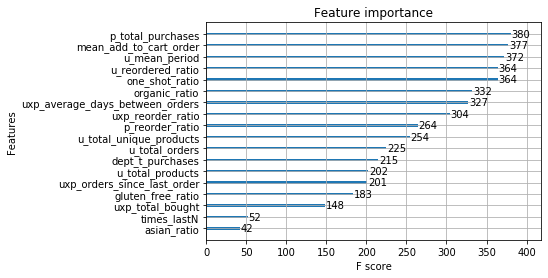

In [64]:
xgb.plot_importance(model)

Plot the tree of the model

ExecutableNotFound: failed to execute ['dot', '-Tpng'], make sure the Graphviz executables are on your systems' PATH

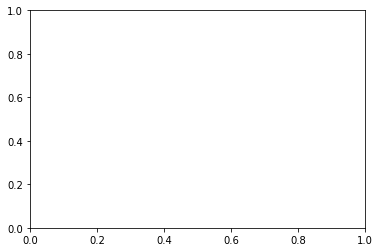

In [65]:
from matplotlib import pyplot
from xgboost import plot_tree
plot_tree(model)
pyplot.show()

## 4.2 Fine-tune your model

Most algorithms have their own parameters that we need to declare. With method .get_params() we can retrieve the parameters of our fitting model

In [ ]:
model.get_xgb_params()

These parameters do not necessarily create the best fitting model (in terms of prediction score). The method .GridSearchCV( ) can make several trials to define the best parameters for our fitting model. 

In [ ]:
###########################
## DISABLE WARNINGS
###########################
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

###########################
## IMPORT REQUIRED PACKAGES
###########################
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

####################################
## SET BOOSTER'S RANGE OF PARAMETERS
# IMPORTANT NOTICE: Fine-tuning an XGBoost model may be a computational prohibitive process with a regular computer or a Kaggle kernel. 
# Be cautious what parameters you enter in paramGrid section.
# More paremeters means that GridSearch will create and evaluate more models.
####################################    
paramGrid = {"max_depth":[5,10],
            "colsample_bytree":[0.3,0.4],
            "eval_metric":["mae", "logloss"],
            "subsample":[0.5, 0.8]}  

########################################
## INSTANTIATE XGBClassifier()
########################################
#no GPU
#xgbc = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', num_boost_round=10)
#with GPU
xgbc = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', num_boost_round=10, gpu_id=0, tree_method = 'gpu_hist')


##############################################
## DEFINE HOW TO TRAIN THE DIFFERENT MODELS
#############################################
gridsearch = GridSearchCV(xgbc, paramGrid, cv=3, verbose=2, n_jobs=1)

##########################################
## SPLIT DF TO: X_train, y_train (axis=1)
##########################################
X_train, y_train = data_train.drop('reordered', axis=1), data_train.reordered

################################################################
## TRAIN THE MODELS
### - with the combinations of different parameters
### - here is where GridSearch will be exeucuted
#################################################################
model = gridsearch.fit(X_train, y_train)

##################################
## OUTPUT(S)
##################################
# Print the best parameters
print("The best parameters are: /n",  gridsearch.best_params_)

# Store the model for prediction (chapter 5)
model = gridsearch.best_estimator_

# Delete X_train , y_train
del [X_train, y_train]

The model has now the new parameters from GridSearchCV:

In [ ]:
model.get_params()

Alternatively, we can use the hyperparameters of the GridSearchCV to train the model using the full set of data below:

In [ ]:
'''
# TRAIN FULL 
###########################
## IMPORT REQUIRED PACKAGES
###########################
import xgboost as xgb

##########################################
## SPLIT DF TO: X_train, y_train (axis=1)
##########################################
X_train, y_train = data_train.drop('reordered', axis=1), data_train.reordered

########################################
## SET BOOSTER'S PARAMETERS
########################################
parameters = {'eval_metric':'mae', 
              'max_depth':'5', 
              'colsample_bytree':'0.4',
              'subsample':'0.8'
             }

########################################
## INSTANTIATE XGBClassifier()
########################################
#no GPU
#xgbc = xgb.XGBClassifier(objective='binary:logistic', parameters=parameters, num_boost_round=10)
#with GPU
xgbc = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', num_boost_round=10, gpu_id=0, tree_method = 'gpu_hist')



########################################
## TRAIN MODEL
########################################
model = xgbc.fit(X_train, y_train)

##################################
# FEATURE IMPORTANCE - GRAPHICAL
##################################
xgb.plot_importance(model)
'''

# 5. Apply predictive model (predict)
The model that we have created is stored in the **model** object.
At this step we predict the values for the test data and we store them in a new column in the same DataFrame.

In [ ]:
## Predict values for test data with our model from chapter 5 - the results are saved as a Python array
#test_pred = model.predict(data_test).astype(int)
#test_pred[0:20] #display the first 20 predictions of the numpy array

In [ ]:
## OR set a custom threshold (in this problem, 0.21 yields the best prediction)
test_pred = (model.predict_proba(data_test)[:,1] >= 0.21).astype(int)
test_pred[0:20] #display the first 20 predictions of the numpy array

In [ ]:
#Save the prediction (saved in a numpy array) on a new column in the data_test DF
data_test['prediction'] = test_pred
data_test.head(10)

In [ ]:
#Reset the index
final = data_test.reset_index()
#Keep only the required columns to create our submission file (for chapter 6)
final = final[['product_id', 'user_id', 'prediction']]

gc.collect()
final.head()

# 6. Creation of Submission File
To submit our prediction to Instacart competition we have to get for each user_id (test users) their last order_id. The final submission file should have the test order numbers and the products that we predict that are going to be bought.

To create this file we retrieve from orders DataFrame all the test orders with their matching user_id:

In [ ]:
orders_test = orders.loc[orders.eval_set=='test',("user_id", "order_id") ]
orders_test.head()

We merge it with our predictions (from chapter 5) using a left join:
<img src="https://i.imgur.com/KJubu0v.jpg" width="400">

In [ ]:
final = final.merge(orders_test, on='user_id', how='left')
final.head()

And we move on with two final manipulations:
- remove any undesired column (in our case user_id)

In [ ]:
#remove user_id column
final = final.drop('user_id', axis=1)


- set product_id column as integer (mandatory action to proceed to the next step)

In [ ]:
#convert product_id as integer
final['product_id'] = final.product_id.astype(int)

## Remove all unnecessary objects
del orders
del orders_test
gc.collect()

final.head()

For our submission file we initiate an empty dictionary. In this dictionary we will place as index the order_id and as values all the products that the order will have. If none product will be purchased, we have explicitly to place the string "None". This syntax follows the submission's file standards defined by the competition.

In [ ]:
d = dict()
for row in final.itertuples():
    if row.prediction== 1:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in final.order_id:
    if order not in d:
        d[order] = 'None'
        
gc.collect()

#We now check how the dictionary were populated (open hidden output)
d

We convert the dictionary to a DataFrame and prepare it to extact it into a .csv file

In [ ]:
#Convert the dictionary into a DataFrame
sub = pd.DataFrame.from_dict(d, orient='index')

#Reset index
sub.reset_index(inplace=True)
#Set column names
sub.columns = ['order_id', 'products']

sub.head()

**The submission file should have 75.000 predictions to be submitted in the competition**

In [ ]:
#Check if sub file has 75000 predictions
sub.shape[0]
print(sub.shape[0]==75000)

The DataFrame can now be converted to .csv file. Pandas can export a DataFrame to a .csv file with the .to_csv( ) function.

In [ ]:
sub.to_csv('sub.csv', index=False)

# 7. Get F1 Score

Before you are ready to submit your prediction to the competion, **ensure that**:
- **You have used all of the offered data and not the 10% that was defined as an optional step on section 1.2**

To submit your prediction and get the F1 score you have to:
1. Commit this notebook and wait for the results 
2. Go to view mode (where you see your notebook but you can't edit it)
3. Click on the data section from your left panel
4. Find the sub.csv (on outputs), below the section with the data from Instacart
5. Click on "Submit to competition" button

Regarding step 1:
>This step might take long. If it exceeds 20-30 minutes it would be wise to check your code again. Kaggle won't inform you during commit if the notebook has:
- syntax errors
- if it exceeds 16 GB RAM
- if it takes an algorirthms too much to train or predict

>Any new commit:
- can't take more than 9 hours
- doesn't stop if it exceeds the 16 GB RAM - you will just receive an error of unsuccesful commit after 9 hours